In [1]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import layers, models, Input, callbacks, regularizers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
#---------------------------------------------------------------------------------------------------------------------------------
#---configs so I don't have to search and change values at 10 different places in the script everytime I want to change smtg
#---(lesson learnt the hard way)
#----------------------------------------------------------------------------------------------------------------------------------

class Config:
    # --- Paths ---
    H5_PATH = "/kaggle/input/aspcapstar-dr17-150kstars/apogee_dr17_parallel.h5" 
    TFREC_DIR = "/kaggle/working/tfrecords"
    STATS_PATH = "/kaggle/working/dataset_stats.npz"
    
    # --- System ---
    TESTING_MODE = True
    TEST_LIMIT = 10000 
    NUM_SHARDS = 16 
    TRAIN_INTEGRATED=True
    TRAIN_BASE_MODEL=True
    RANDOM_SEED=42
    # --- Model Hyperparameters ---
    BATCH_SIZE = 512       
    LEARNING_RATE = 1e-3  
    EPOCHS = 50
    LATENT_DIM = 268
    OUTPUT_LENGTH = 8575
    # --loss related---
    L2_VAL = 1e-4          
    INPUT_NOISE = 0.05     
    IVAR_SCALE = 1000.0   
    CLIP_NORM = 1.0     
    BADPIX_CUTOFF=1e-3  
    #----predictor-labels--------
    #CAUTION: LITERALLY EVERYTHING IS IN THE SAME ORDER AS THESE LABELS. DO NOT TOUCH THE ORDER OF THESE LABELS
    SELECTED_LABELS = [
        # 1. Core
        'TEFF', 'LOGG', 'FE_H', 'VMICRO', 'VMACRO', 'VSINI',
        # 2. CNO
        'C_FE', 'N_FE', 'O_FE',
        #3. metals
        'MG_FE', 'SI_FE', 'CA_FE', 'TI_FE', 'S_FE',
        'AL_FE', 'MN_FE', 'NI_FE', 'CR_FE','K_FE',
        'NA_FE','V_FE','CO_FE'
    ]
    ABUNDANCE_INDICES =[]#[i for i, label in enumerate(SELECTED_LABELS) if '_FE' in label]
    FE_H_INDEX = SELECTED_LABELS.index('FE_H')
    N_LABELS = len(SELECTED_LABELS) + 4
    #GRAPHING:
    WAVELENGTH_START = 1514
    WAVELENGTH_END = 1694 


config = Config()
np.random.seed(config.RANDOM_SEED)
tf.random.set_seed(config.RANDOM_SEED)
os.makedirs(config.TFREC_DIR, exist_ok=True)

2026-01-23 15:03:16.532251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769180596.745356      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769180596.804926      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769180597.289829      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769180597.289866      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769180597.289868      55 computation_placer.cc:177] computation placer alr

In [2]:
"""Get the percentage of NaN values in each label"""
def get_nans(h5_path, selected_labels):
    print(f"Scanning {len(selected_labels)} labels for missing data...")
    print(f"{'LABEL':<10} | {'MISSING %':<10} | {'STATUS'}")
    
    missing_report = {}
    
    with h5py.File(h5_path, 'r') as f:
        #print all labels
        #print(f['metadata'].dtype.names)
        get_col = lambda k: f['metadata'][k]
        keys = f['metadata'].dtype.names

        # Get total count 
        total_stars = len(get_col(selected_labels[0]))
        
        for label in selected_labels:
            raw_vals = get_col(label)
        
            flag_name = f"{label}_FLAG"
            if flag_name in keys:
                flg = get_col(flag_name)
                # Handle Void/Structured types
                if flg.dtype.names: flg = flg[flg.dtype.names[0]]
                if flg.dtype.kind == 'V': flg = flg.view('<i4')
                
                # Bad if Flag != 0
                is_bad_flag = (flg.astype(int) != 0)
            else:
                is_bad_flag = np.zeros(total_stars, dtype=bool)
                
            # 3. Check Placeholder Values or weird values (Standard APOGEE -9999)
            is_bad_val = (raw_vals < -100)
            
           
            total_bad = np.logical_or(is_bad_flag, is_bad_val)
            bad_count = np.sum(total_bad)
            pct = (bad_count / total_stars) * 100
            missing_report[label] = pct
            
            # 6. report status
            if pct < 5.0:
                status = "Great"
            elif pct < 20.0:
                status = "Okay"
            else:
                status = "Unacceptable"
            
            print(f"{label:<10} | {pct:>9.2f}% | {status}")

    print("-" * 50)
    return missing_report
#missing_report=get_nans(config.H5_PATH,config.SELECTED_LABELS)

In [4]:
#==================================

def get_clean_imputed_data(h5_path, selected_labels, limit=None):
    
    print("Read data for imputation")
    
    with h5py.File(h5_path, 'r') as f:
        #check keys
        #print(f.keys())
       
        get_col = lambda k: f['metadata'][k]
        keys = f['metadata'].dtype.names

        raw_values = np.stack([get_col(p) for p in selected_labels], axis=1)
        bad_mask = np.zeros_like(raw_values, dtype=bool)
        
        for i, label in enumerate(selected_labels):
            flag_name = f"{label}_FLAG"
            if flag_name in keys:
                flg = get_col(flag_name)
                #Handle Void/Structured Types safely
                if flg.dtype.names: flg = flg[flg.dtype.names[0]]
                if flg.dtype.kind == 'V': flg = flg.view('<i4')
                is_bad = (flg.astype(int) != 0)
            elif label in ['TEFF', 'LOGG', 'VMICRO', 'VMACRO', 'VSINI']:
                is_bad = (raw_values[:, i] < -5000)
            else:
                is_bad = np.zeros_like(raw_values[:, i], dtype=bool)
            bad_mask[:, i] = is_bad

    if limit:
        print(f"Truncating to first {limit} stars.")
        raw_values = raw_values[:limit]
        bad_mask = bad_mask[:limit]

    print(f"Imputing Labels for {len(raw_values)} stars...")
    vals_to_impute = raw_values.copy()
    vals_to_impute[bad_mask] = np.nan
    
    imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, initial_strategy='median')
    clean_labels = imputer.fit_transform(vals_to_impute)
    print("Converting [X/Fe] to [X/H]...")
    
    # Get the Iron Abundance column
    fe_h_col = clean_labels[:, config.FE_H_INDEX : config.FE_H_INDEX+1] 
    
    # Loop through all metal columns and add iron
    for idx in config.ABUNDANCE_INDICES:
        clean_labels[:, idx] = clean_labels[:, idx] + fe_h_col[:, 0]
        
    try:
        #calculate Inverse temperature to help with spectral lines
        teff_idx = selected_labels.index('TEFF')
        teff_vals = clean_labels[:, teff_idx]
        
        inv_teff = 5040.0 / (teff_vals + 1e-6)
        inv_teff = inv_teff.reshape(-1, 1)
        
        # Stack it onto the end of the array
        clean_labels = np.hstack([clean_labels, inv_teff])
        
    except ValueError:
        print("TEFF not found in labels")
         
  #  try:
        #calculate Inverse temperature to help with spectral lines
    vmacro_idx = selected_labels.index('VMACRO')
    vmacro_vals = clean_labels[:, vmacro_idx]
       
    vsini_idx = selected_labels.index('VSINI')
    vsini_vals = clean_labels[:, vsini_idx]
        # Stack it onto the end of the array
    quadrature=np.sqrt(np.square(vmacro_vals)+np.square(vsini_vals))
    quadrature = quadrature.reshape(-1, 1)
    clean_labels = np.hstack([clean_labels, quadrature])
        
   # except ValueError:
   #     print("VMARCRO or VSINI not found in labels")
    
    try:
  
        C_idx = selected_labels.index('C_FE')
        C_vals = clean_labels[:, C_idx]
       
        O_idx = selected_labels.index('O_FE')
        O_vals = clean_labels[:, O_idx]
        C_O_diff=C_vals-O_vals
        C_O_diff=C_O_diff.reshape(-1,1)
        clean_labels = np.hstack([clean_labels, C_O_diff])
        
    except ValueError:
        print("C_FE or O_FE not found in labels")
    
    try:
  
        G_idx = selected_labels.index('LOGG')
        G_vals = clean_labels[:, G_idx]
       
        FE_idx = selected_labels.index('FE_H')
        FE_vals = clean_labels[:, FE_idx]
        LOGPE=G_vals+0.5*FE_vals
        LOGPE=LOGPE.reshape(-1,1)
        clean_labels = np.hstack([clean_labels, LOGPE])
        
    except ValueError:
        print("FE_H or LOGG not found in labels")

    print(f"Transformation Complete. Final Input Shape: {clean_labels.shape}")
    
    return clean_labels

def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def generate_tfrecords():
    #Converts H5 to TFRecords
    print(f"Starting TFRecord Generation (Shards: {config.NUM_SHARDS})...")
    limit = config.TEST_LIMIT if config.TESTING_MODE else None
    
    # 1. Clean Labels
    clean_labels = get_clean_imputed_data(config.H5_PATH, config.SELECTED_LABELS, limit=limit)
    
    # 2. Save Stats
    mean_labels = np.mean(clean_labels, axis=0)
    std_labels = np.std(clean_labels, axis=0)
    std_labels[std_labels == 0] = 1.0 
    np.savez(config.STATS_PATH, mean=mean_labels, std=std_labels)
    print(f"Stats saved to {config.STATS_PATH}")
    
    # 3. Write Shards
    total_stars = len(clean_labels)
    shard_size = int(np.ceil(total_stars / config.NUM_SHARDS))
    
    with h5py.File(config.H5_PATH, 'r') as f:
        ds_flux = f['flux']
        ds_ivar = f['ivar']
        
        for shard_id in range(config.NUM_SHARDS):
            start_idx = shard_id * shard_size
            end_idx = min((shard_id + 1) * shard_size, total_stars)
            if start_idx >= total_stars: break
            
            filename = os.path.join(config.TFREC_DIR, f"data_{shard_id:02d}.tfrec")
            print(f"   Writing Shard {shard_id+1}/{config.NUM_SHARDS}: {filename}")
            
            with tf.io.TFRecordWriter(filename) as writer:
                chunk_flux = ds_flux[start_idx:end_idx]
                chunk_ivar = ds_ivar[start_idx:end_idx]
                chunk_labels = clean_labels[start_idx:end_idx]
                
                for i in range(len(chunk_labels)):
                    label_bytes = tf.io.serialize_tensor(chunk_labels[i].astype(np.float32))
                    spec_raw = np.stack([chunk_flux[i], chunk_ivar[i]], axis=-1).astype(np.float32)
                    spec_bytes = tf.io.serialize_tensor(spec_raw)
                    
                    feature = {'labels': _bytes_feature(label_bytes), 'spectra': _bytes_feature(spec_bytes)}
                    writer.write(tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString())
    print("TFRecord Generation Complete.")

# Generate if missing
if not glob.glob(os.path.join(config.TFREC_DIR, "*.tfrec")):
    generate_tfrecords()
else:
    print("TFRecords found. Skipping generation.")

Starting TFRecord Generation (Shards: 16)...
Read data for imputation
Truncating to first 10000 stars.
Imputing Labels for 10000 stars...
Converting [X/Fe] to [X/H]...
Transformation Complete. Final Input Shape: (10000, 26)
Stats saved to /kaggle/working/dataset_stats.npz
   Writing Shard 1/16: /kaggle/working/tfrecords/data_00.tfrec


I0000 00:00:1769181006.716150      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   Writing Shard 2/16: /kaggle/working/tfrecords/data_01.tfrec
   Writing Shard 3/16: /kaggle/working/tfrecords/data_02.tfrec
   Writing Shard 4/16: /kaggle/working/tfrecords/data_03.tfrec
   Writing Shard 5/16: /kaggle/working/tfrecords/data_04.tfrec
   Writing Shard 6/16: /kaggle/working/tfrecords/data_05.tfrec
   Writing Shard 7/16: /kaggle/working/tfrecords/data_06.tfrec
   Writing Shard 8/16: /kaggle/working/tfrecords/data_07.tfrec
   Writing Shard 9/16: /kaggle/working/tfrecords/data_08.tfrec
   Writing Shard 10/16: /kaggle/working/tfrecords/data_09.tfrec
   Writing Shard 11/16: /kaggle/working/tfrecords/data_10.tfrec
   Writing Shard 12/16: /kaggle/working/tfrecords/data_11.tfrec
   Writing Shard 13/16: /kaggle/working/tfrecords/data_12.tfrec
   Writing Shard 14/16: /kaggle/working/tfrecords/data_13.tfrec
   Writing Shard 15/16: /kaggle/working/tfrecords/data_14.tfrec
   Writing Shard 16/16: /kaggle/working/tfrecords/data_15.tfrec
TFRecord Generation Complete.


In [5]:
# Load Stats
stats = np.load(config.STATS_PATH)
MEAN_TENSOR = tf.constant(stats['mean'], dtype=tf.float32)
STD_TENSOR = tf.constant(stats['std'], dtype=tf.float32)

# ==========================================
 
# ==========================================
def parse_and_normalize(example_proto):
    feature_desc = {
        'labels': tf.io.FixedLenFeature([], tf.string),
        'spectra': tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(example_proto, feature_desc)
    labels = tf.io.parse_tensor(parsed['labels'], out_type=tf.float32)
    spectra = tf.io.parse_tensor(parsed['spectra'], out_type=tf.float32)
    
    labels.set_shape([config.N_LABELS])
    spectra.set_shape([config.OUTPUT_LENGTH, 2])
    
    norm_labels = (labels - MEAN_TENSOR) / STD_TENSOR
    return norm_labels, spectra

def build_dataset():
    all_files = sorted(tf.io.gfile.glob(os.path.join(config.TFREC_DIR, "*.tfrec")))
    split_idx = int(len(all_files) * 0.8)
    if split_idx == len(all_files): split_idx -= 1
    
    train_files = all_files[:split_idx]
    val_files = all_files[split_idx:]
    print(f"Data Split: {len(train_files)} Train Files, {len(val_files)} Val Files")
    
    def load_files(filenames):
        ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
        ds = ds.map(parse_and_normalize, num_parallel_calls=tf.data.AUTOTUNE)
        return ds
    
    train_ds = load_files(train_files).shuffle(10000).batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds = load_files(val_files).batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds

train_ds, val_ds = build_dataset()

Data Split: 12 Train Files, 4 Val Files


In [6]:

spectral_lines_pixels = {
    "Fe_1519": 250,
    "Mn_1526": 599,
    "CN_1533": 947,
    "Fe_1539": 1244,
    "CO_1558": 2176,
    "Fe/Ti_1569": 2710,
    "Mg_1576": 3048,
    "Si_1596": 4004,
    "Ni_1605": 4432,
    "Ca/Fe_1615": 4905,
    "CO_1619": 5092,
    "Si_1638": 5970,
    "CO_1661": 7032,
    "Ni_1667": 7306,
    "Al_1672": 7536,
    "Al_1675": 7669,
    "Ni_1682": 7987
}

Scanning AL_FE around Pixel 7536 (Radius: 0)...


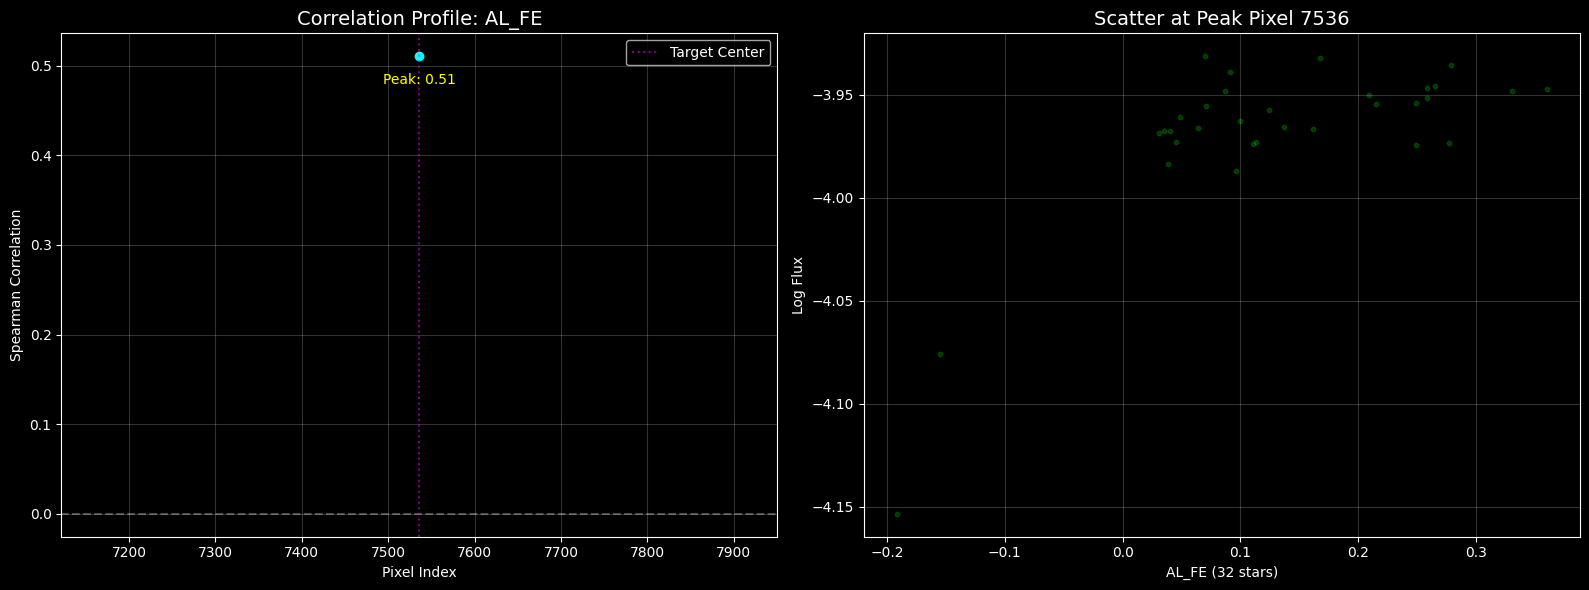

Strongest Correlation: 0.511 at Pixel 7536


In [8]:

def check_window_correlation(dataset, label_name, center_pixel, config, window_radius=3, num_samples=10000):
    """
    Checks correlation for a label across a range of pixels [center-r, center+r].
    Generates a 'Correlation Profile' plot to prove the line exists physically.
    """
    # 1. Identify Label Index
    try:
        label_idx = config.SELECTED_LABELS.index(label_name)
    except ValueError:
        print(f"Label {label_name} not found.")
        return

    print(f"Scanning {label_name} around Pixel {center_pixel} (Radius: {window_radius})...")

    # 2. Collect Data (Labels + Window of Flux)
    collected_labels = []
    collected_flux_window = []
    
    # Define pixel range
    start_pix = max(0, center_pixel - window_radius)
    end_pix = min(config.OUTPUT_LENGTH, center_pixel + window_radius + 1)
    pixel_indices = np.arange(start_pix, end_pix)
    
    count = 0
    for batch_labels, batch_spectra in dataset:
        batch_labels=batch_labels*STD_TENSOR+MEAN_TENSOR
        lbls = batch_labels.numpy()[:, label_idx]
        # Grab the specific slice of pixels
        flux_window = batch_spectra.numpy()[:, start_pix:end_pix, 0]
        #lbls=lbls[np.any(flux_window<1e-2)]
       # flux_window=flux_window[np.any(flux_window<1e-2)]
        if(np.any(batch_spectra.numpy()[:,start_pix:end_pix,1]==0)):
            continue
        collected_labels.extend(lbls)
        collected_flux_window.extend(flux_window)
        
        count += len(lbls)
        if count >= num_samples: break
            
    # Convert to arrays
    X_labels = np.array(collected_labels)
    Y_flux_window = np.array(collected_flux_window) # Shape: (N_samples, Window_Size)
    X_labels=X_labels[np.any(Y_flux_window<1e-2,axis=1)]
    Y_flux_window=Y_flux_window[np.any(Y_flux_window<1e-2,axis=1)]
    #X_labels[Y_flux_window]
    # 3. Calculate Correlation per Pixel
    correlations = []
    p_values = []
    
    for i in range(Y_flux_window.shape[1]):
        pixel_flux = Y_flux_window[:, i]
        corr, p_val = spearmanr(X_labels, pixel_flux)
        correlations.append(corr)
        p_values.append(p_val)
        
    # 4. Plotting
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    
    # --- PLOT A: Correlation Profile ---
    # This shows if the correlation is "localized" (a real line) or random noise.
    ax1.plot(pixel_indices, correlations, color='cyan', marker='o', linestyle='-')
    ax1.axhline(0, color='white', alpha=0.3, linestyle='--')
    ax1.axvline(center_pixel, color='magenta', alpha=0.5, linestyle=':', label='Target Center')
    
    ax1.set_title(f"Correlation Profile: {label_name}", fontsize=14, color='white')
    ax1.set_xlabel("Pixel Index")
    ax1.set_ylabel("Spearman Correlation")
    ax1.grid(True, alpha=0.2)
    ax1.legend()
    
    # Annotate the strongest pixel
    best_idx = np.argmin(correlations)
    best_pixel = pixel_indices[best_idx]
    best_corr = correlations[best_idx]
    
    ax1.annotate(f"Peak: {best_corr:.2f}", 
                 (best_pixel, best_corr), 
                 xytext=(0, -20), textcoords='offset points', 
                 color='yellow', ha='center')

    # --- PLOT B: Scatter of Best Pixel ---
    # Shows the raw data for the strongest correlated pixel found
    best_flux = Y_flux_window[:, best_idx]
    
    ax2.scatter(X_labels,np.log10(best_flux), alpha=0.2, s=10, color='lime')
    
    ax2.set_title(f"Scatter at Peak Pixel {best_pixel}", fontsize=14, color='white')
    ax2.set_xlabel(f"{label_name} ({len(X_labels)} stars)")
    ax2.set_ylabel("Log Flux")
    ax2.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Strongest Correlation: {best_corr:.3f} at Pixel {best_pixel}")

# ==========================================
# USAGE
# ==========================================
# Example: Check Aluminum around the 16719A line
# (Assuming pixel index ~7250, adjust based on your grid)
target_pixel = 7250 

check_window_correlation(
    train_ds, 
    label_name='AL_FE', 
    center_pixel=spectral_lines_pixels['Al_1672'], 
    config=config, 
    window_radius=0 # Check 5 pixels left/right
)

In [9]:
# ==========================================
# Use a modiefied soblev loss function (I read in a paper it works well)
# ==========================================

@register_keras_serializable()
def sobolev_loss(y_true, y_pred):
    real_flux = y_true[:, :, 0:1]
    ivar = y_true[:, :, 1:2]
    valid_mask = tf.cast(real_flux > config.BADPIX_CUTOFF, tf.float32)    
    safe_flux = tf.where(valid_mask == 1.0, real_flux, y_pred)
    ivar_safe = tf.clip_by_value(ivar / 1000.0, 0.0, 1.0)# scale and clip
    weight=tf.where(((safe_flux<0.9) & (ivar>0)),tf.maximum(ivar_safe,tf.cast(1.0,dtype=tf.float32)),ivar_safe)
    #chi2
    wmse_term = tf.square(safe_flux - y_pred) * weight * valid_mask
    # calculate "gradients" (difference between adjacent pixels)
    true_grad = safe_flux[:, 1:, :] - safe_flux[:, :-1, :]
    pred_grad = y_pred[:, 1:, :] - y_pred[:, :-1, :]
    
    # Calculate Squared Error of gradients (sobolev loss term)
    grad_sq_diff = tf.square(true_grad - pred_grad)
    grad_mask = valid_mask[:, 1:, :] * valid_mask[:, :-1, :]
    grad_trust = (weight[:, 1:, :] * weight[:, :-1, :])
    # Apply mask to gradient loss
    grad_loss = grad_sq_diff * grad_mask * grad_trust
    
    #pad last pixel
    grad_loss = tf.pad(grad_loss, [[0,0], [0,1], [0,0]])
    
    # final loss
    total_loss = (wmse_term + (10.0 * grad_loss))
    
    #safety check
    loss = tf.where(tf.math.is_finite(total_loss), total_loss, tf.zeros_like(total_loss))
    
    return tf.reduce_mean(loss)  

In [10]:
# ==========================================
# Array version so I plot the loss
# ==========================================

def sobolev_loss_arr(y_true, y_pred):
    real_flux = y_true[:, :, 0:1]
    ivar = y_true[:, :, 1:2]
    valid_mask = tf.cast(real_flux > config.BADPIX_CUTOFF, tf.float32)    
    safe_flux = tf.where(valid_mask == 1.0, real_flux, y_pred)
    ivar_safe = tf.clip_by_value(ivar / 1000.0, 0.0, 1.0)# scale and clip
    weight=tf.where(((safe_flux<0.9) & (ivar>0)),tf.maximum(ivar_safe,tf.cast(1.0,dtype=tf.float32)),ivar_safe)
    #chi2
    wmse_term = tf.square(safe_flux - y_pred) * weight * valid_mask
    
    # calculate "gradients" (difference between adjacent pixels)
    true_grad = safe_flux[:, 1:, :] - safe_flux[:, :-1, :]
    pred_grad = y_pred[:, 1:, :] - y_pred[:, :-1, :]
    
    # Calculate Squared Error of gradients (sobolev loss term)
    grad_sq_diff = tf.square(true_grad - pred_grad)
    grad_mask = valid_mask[:, 1:, :] * valid_mask[:, :-1, :]
    grad_trust = (weight[:, 1:, :] * weight[:, :-1, :])
    # Apply mask to gradient loss
    grad_loss = grad_sq_diff * grad_mask * grad_trust
    
    #pad last pixel
    grad_loss = tf.pad(grad_loss, [[0,0], [0,1], [0,0]])
    
    # final loss
    total_loss = (wmse_term + (10.0 * grad_loss))
    
    #safety check
    loss = tf.where(tf.math.is_finite(total_loss), total_loss, tf.zeros_like(total_loss))
    
    return loss

In [11]:
#scaled the sigmoid function so my model can actually predict 1.0 and 0.0
# most probably  there are better ways to do this, but I don't know any

@register_keras_serializable()
def scaled_sigmoid(x):
    return 1.3 * tf.nn.sigmoid(x)-0.15


def build_model():
    input_dim = config.N_LABELS
    inputs = Input(shape=(input_dim,))
    #Adding guassian noise just in case my model fits too well (:clown face:)
    #x = layers.GaussianNoise(config.INPUT_NOISE)(inputs)
    x=inputs
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(config.L2_VAL))(x)
    
    #268*32 IS 8576 , very close to our output shape (8575)
    x = layers.Dense(config.LATENT_DIM * 32, activation='relu',\
                     kernel_regularizer=regularizers.l2(config.L2_VAL))(x) # punish extreme weights
    x = layers.Reshape((config.LATENT_DIM, 32))(x)
    
    #Progessively sharpen the image
    filters = [64, 32, 32, 16, 16]
    kernels = [7,  7,  5,  5,  3]

    #residual blocks
    for f, k in zip(filters, kernels):
        x = layers.UpSampling1D(size=2)(x)
        res = layers.Conv1D(f, 1, padding='same', kernel_regularizer=regularizers.l2(config.L2_VAL))(x)
        x = layers.Conv1D(f, kernel_size=k, padding='same', kernel_regularizer=regularizers.l2(config.L2_VAL))(x)
        x = layers.Activation('relu')(x)
        x = layers.SpatialDropout1D(0.1)(x) #avoid overfitting
        x = layers.Add()([x, res])

    #final layer (crop the last pixel so output shape becomes 8575)
    x = layers.Conv1D(1, kernel_size=3, padding='same', activation=scaled_sigmoid)(x)
    outputs = layers.Cropping1D(cropping=(0, 1))(x)
    
    return models.Model(inputs, outputs, name="Spectrogram_Emulator")

In [12]:
#-----------------------
#     TRAIN THE MODEL
#-----------------------
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(config.LEARNING_RATE, clipnorm=config.CLIP_NORM), 
              loss=sobolev_loss)

callbacks_list = [
    callbacks.ModelCheckpoint('best_emulator.keras', save_best_only=True, monitor='val_loss'),
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=1, factor=0.5, min_lr=1e-6, verbose=1)
]

if config.TRAIN_BASE_MODEL:
    print("BEGIN TRAINING")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config.EPOCHS,
        callbacks=callbacks_list,
        verbose=1
    )

BEGIN TRAINING
Epoch 1/50


I0000 00:00:1769181683.952151     251 service.cc:152] XLA service 0x7c8d48075810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769181683.952194     251 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769181685.362907     251 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-23 15:21:40.137974: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv.41 = (f32[32,16,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,1,4288]{3,2,1,0} %bitcast.22250, f32[16,512,1,4288]{3,2,1,0} %bitcast.22259), window={size=1x4288}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/Spectrogram_Emulator_1/conv1d_6_1/convolution/Conv2DBackpropFilter" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_confi

     14/Unknown 72s 1s/step - loss: 0.1912

2026-01-23 15:22:41.115628: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv.41 = (f32[32,16,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,332,1,4288]{3,2,1,0} %bitcast.22250, f32[16,332,1,4288]{3,2,1,0} %bitcast.22259), window={size=1x4288}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/Spectrogram_Emulator_1/conv1d_6_1/convolution/Conv2DBackpropFilter" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-01-23 15:22:41.967915: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.852479823s
Trying algorithm eng0{} fo

     15/Unknown 106s 3s/step - loss: 0.1876

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - loss: 0.1844 - val_loss: 0.1009 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0965 - val_loss: 0.0849 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0819 - val_loss: 0.0740 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0702 - val_loss: 0.0548 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0526 - val_loss: 0.0451 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0445 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0406 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0380 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0361 - val_loss: 0.0347 - learning_rate: 0.0010
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━

In [13]:
model.save('SPECTROGRAM_GENERATOR.keras')

In [14]:
# Helper function for SE Block
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling1D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)
    return layers.Multiply()([input_tensor, se])

def build_unet_refiner(output_length=config.OUTPUT_LENGTH, label_dim=config.N_LABELS):
    label_input = Input(shape=(label_dim,), name="labels")
    base_spec_input = Input(shape=(output_length, 1), name="base_spec")
    
    # Expand Labels
    x_labels = layers.Dense(32, activation='relu')(label_input)
    x_labels = layers.RepeatVector(output_length)(x_labels)
    x0 = layers.Concatenate()([base_spec_input, x_labels])
    
    # --- ENCODER ---
    # Level 1
    c1 = layers.Conv1D(32, 3, activation='relu', padding='same')(x0)
    c1 = layers.Conv1D(32, 3, activation='relu', padding='same')(c1)
    c1 = se_block(c1)
    p1 = layers.MaxPooling1D(2)(c1)
    
    # Level 2
    c2 = layers.Conv1D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv1D(64, 3, activation='relu', padding='same')(c2)
    c2 = se_block(c2) 
    p2 = layers.MaxPooling1D(2)(c2)
    
    # Level 3 (Bottleneck)
    c3 = layers.Conv1D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv1D(128, 3, activation='relu', padding='same')(c3)
    c3 = se_block(c3)
    
    # --- DECODER ---
    # Level 2 Up
    u2 = layers.UpSampling1D(2)(c3)
    if u2.shape[1] != c2.shape[1]: u2 = layers.ZeroPadding1D((0, c2.shape[1]-u2.shape[1]))(u2)
    u2 = layers.Concatenate()([u2, c2])
    c4 = layers.Conv1D(64, 3, activation='relu', padding='same')(u2)
    c4 = se_block(c4)
    
    # Level 1 Up
    u1 = layers.UpSampling1D(2)(c4)
    if u1.shape[1] != c1.shape[1]: u1 = layers.ZeroPadding1D((0, c1.shape[1]-u1.shape[1]))(u1)
    u1 = layers.Concatenate()([u1, c1])
    c5 = layers.Conv1D(32, 3, activation='relu', padding='same')(u1)
    c5 = se_block(c5)  # <--- NEW
    
    outputs = layers.Conv1D(1, 1, activation='linear', name="residual_output")(c5)
    
    if outputs.shape[1] != output_length:
        outputs = layers.Resizing(output_length, 1)(outputs)

    return models.Model([label_input, base_spec_input], outputs, name="UNet_Refiner_SE")

In [15]:
def build_integrated_model(base_model_path, student_model):
    # 1. Load & Freeze Base Model
    base_model = tf.keras.models.load_model(base_model_path, compile=False)
    base_model.trainable = False
    base_model.training = False 
    
    # 2. Define Input
    label_input = Input(shape=(config.N_LABELS,), name="labels_input")
    
    # 3. Get Base Prediction (The "Draft")
    # This is the smooth continuum
    base_pred = base_model(label_input, training=False)
    
    # 4. Get Student Correction
    # Student sees [Labels, Draft] and predicts the "Dip"
    correction = student_model([label_input, base_pred])
    
    # --- THE CHANGE ---
    # 5. Add them together!
    # Final Output = Base (1.0) + Correction (-0.4) = 0.6
    final_output = layers.Add(name="final_spectrum")([base_pred, correction])
    
    return models.Model(inputs=label_input, outputs=final_output, name="Integrated_Refiner")

In [16]:
@tf.keras.saving.register_keras_serializable(package="Custom")
def spectral_focus_loss(y_true, y_pred):
    """
    A loss function designed specifically for the Refiner Stage.
    It aggressively ignores continuum noise and focuses on absorption lines.
    """
    real_flux = y_true[:, :, 0:1]
    ivar = y_true[:, :, 1:2]
    
    # 1. Mask Poison Data (-9999)
    valid_mask = tf.cast(real_flux >  config.BADPIX_CUTOFF, tf.float32)
    safe_flux = tf.where(valid_mask == 1.0, real_flux, y_pred)
    
    # 2. Scale Ivar
    ivar_safe = tf.clip_by_value(ivar / 1000.0, 0.0, 1.0)
    weight=tf.where(((safe_flux<0.9) & (ivar>0)),tf.maximum(ivar_safe,tf.cast(1.0,dtype=tf.float32)),ivar_safe)
    # 3. DEFINE ZONES
    # Line Zone: Where physics happens (Flux < 0.9)
    # Continuum Zone: Where noise happens (Flux >= 0.9)
    is_line = tf.cast(safe_flux < 0.9, tf.float32)
    is_continuum = 1.0 - is_line
    
    # 4. ASSIGN WEIGHTS
    # Lines: Weight 15 (High Priority)
    # Continuum: Weight 1 (Low Priority - prevent drift, but ignore noise)
    zone_weight = (is_line *15.0) + (is_continuum * 1.0)
    
    # 5. Combined Weight
    # We multiply by ivar to ensure we don't fit dead pixels in the line region
    final_weight = zone_weight * weight * valid_mask
    
    # 6. Calculate MSE
    squared_diff = tf.square(safe_flux - y_pred)
    weighted_loss = squared_diff * final_weight
    
    # 7. Safety
    loss = tf.where(tf.math.is_finite(weighted_loss), weighted_loss, tf.zeros_like(weighted_loss))
    
    return tf.reduce_mean(loss)

In [17]:


# 2. Build the Components
unet = build_unet_refiner() # The Student
integrated_model = build_integrated_model('SPECTROGRAM_GENERATOR.keras', unet)

# 3. Compile
# We use your custom loss because it handles the physics/noise better than MSE
integrated_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    loss=spectral_focus_loss
)

# 4. Train!
# The model receives Labels -> Predicts Spectrum
# It calculates Loss(True_Spectrum, Pred_Spectrum)
if config.TRAIN_INTEGRATED:
    history = integrated_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[
            callbacks.ModelCheckpoint('full_model.keras', save_best_only=True, monitor='val_loss'),
            callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(patience=1, factor=0.5, min_lr=1e-6, verbose=1)
        ]
    )

Epoch 1/30


2026-01-23 15:37:05.786113: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-input.8 = (f32[512,96,1,8575]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,32,1,8575]{3,2,1,0} %bitcast.21895, f32[32,96,1,3]{3,2,1,0} %bitcast.19904), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/Integrated_Refiner_1/UNet_Refiner_SE_1/conv1d_18_1/convolution/Conv2DBackpropInput" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-01-23 15:37:06.153039: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1

     14/Unknown 93s 2s/step - loss: 0.0038

2026-01-23 15:38:32.755578: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-input.9 = (f32[332,192,1,4287]{3,2,1,0}, u8[0]{0}) custom-call(f32[332,64,1,4287]{3,2,1,0} %bitcast.19997, f32[64,192,1,3]{3,2,1,0} %bitcast.20001), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/Integrated_Refiner_1/UNet_Refiner_SE_1/conv1d_17_1/convolution/Conv2DBackpropInput" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-01-23 15:38:33.503075: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took

15/15 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - loss: 0.0038 - val_loss: 0.0024 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0032 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0030
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0030 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0030 - val_loss: 0.0021 - learning_rate: 5.0000e-05
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0029
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0029 - val_loss: 0.0021 - learning_rate: 5.0000e-05
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0029
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.002

In [18]:
integrated_model.save("/kaggle/working/final_model.keras")

In [19]:
integrated_model.summary()

Model: "Integrated_Refiner"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ labels_input        │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Spectrogram_Emulat… │ (None, 8575, 1)   │  2,254,321 │ labels_input[0][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_Refiner_SE     │ (None, 8575, 1)   │    149,249 │ labels_input[0][… │
│ (Functional)        │                   │            │ Spectrogram_Emul… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_spectrum      │ (None, 8575, 1)   │          0 │ Spectrogram_Emul… │
│ (Add)               │                   │            │ UNet_Refiner_SE[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,702,070 (10.31 MB)

 Trainable params: 149,249 (583.00 KB)

 Non-trainable params: 2,254,321 (8.60 MB)

 Optimizer params: 298,500 (1.14 MB)

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def debug_prediction(integrated_model, input_labels, idx_to_plot=0):
    """
    Manually runs Base -> Secodary -> Sum to see intermediate steps.
    """  
    
    base_submodel = integrated_model.get_layer("Spectogram_Emulator")
    secondary_submodel = integrated_model.get_layer("UNet_Refiner_SE")
    

    # 2. Run Base Model
    print("Running Base Model...")
    base_pred = base_submodel.predict(input_labels, verbose=0)

    # 3. Run Corrector
    print("Running Refiner...")
    correction_pred = secondary_submodel.predict([input_labels, base_pred], verbose=0)

    # 4. Combine
    final_pred = base_pred + correction_pred
    
    # --- PLOTTING ---
    # Extract just the specific star index for plotting
    wave = np.logspace(np.log10(1514),np.log10(1695),config.OUTPUT_LENGTH)
    
    plt.figure(figsize=(14, 8))
    plt.style.use('dark_background')
    
    # Plot Base (Smooth)
    plt.plot(wave, base_pred[idx_to_plot], color='cyan', linestyle='--', alpha=0.6, label='Base Model (Continuum)')
    
    # Plot Correction (What the Student added)
    # We shift it up by 1.0 just for visualization so it doesn't sit at bottom
    plt.plot(wave, correction_pred[idx_to_plot], color='red', alpha=0.8, linewidth=1, label='Student Correction (Residual)')
    
    # Plot Final
    plt.plot(wave, final_pred[idx_to_plot], color='green', alpha=0.6, linewidth=1.5, label='Final Integrated Output')
    
    plt.title(f"Model Deconstruction (Star {idx_to_plot})")
    plt.ylabel("Flux")
    plt.xlabel("Wavelength")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()
    
    return base_pred, correction_pred, final_pred


for batch_labels, batch_spectra in val_ds.take(1):
    b, c, f = debug_prediction(model, batch_labels[0:5], idx_to_plot=0)

ValueError: No such layer: Spectogram_Emulator. Existing layers are: ['input_layer', 'dense', 'dense_1', 'reshape', 'up_sampling1d', 'conv1d_1', 'activation', 'spatial_dropout1d', 'conv1d', 'add', 'up_sampling1d_1', 'conv1d_3', 'activation_1', 'spatial_dropout1d_1', 'conv1d_2', 'add_1', 'up_sampling1d_2', 'conv1d_5', 'activation_2', 'spatial_dropout1d_2', 'conv1d_4', 'add_2', 'up_sampling1d_3', 'conv1d_7', 'activation_3', 'spatial_dropout1d_3', 'conv1d_6', 'add_3', 'up_sampling1d_4', 'conv1d_9', 'activation_4', 'spatial_dropout1d_4', 'conv1d_8', 'add_4', 'conv1d_10', 'cropping1d'].

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


/tmp/ipykernel_55/3760574896.py:80: RuntimeWarning: divide by zero encountered in log
  ax3.plot(wavelengths,np.log(ivar)-10,color='red',linewidth=0.8)


(8575,)


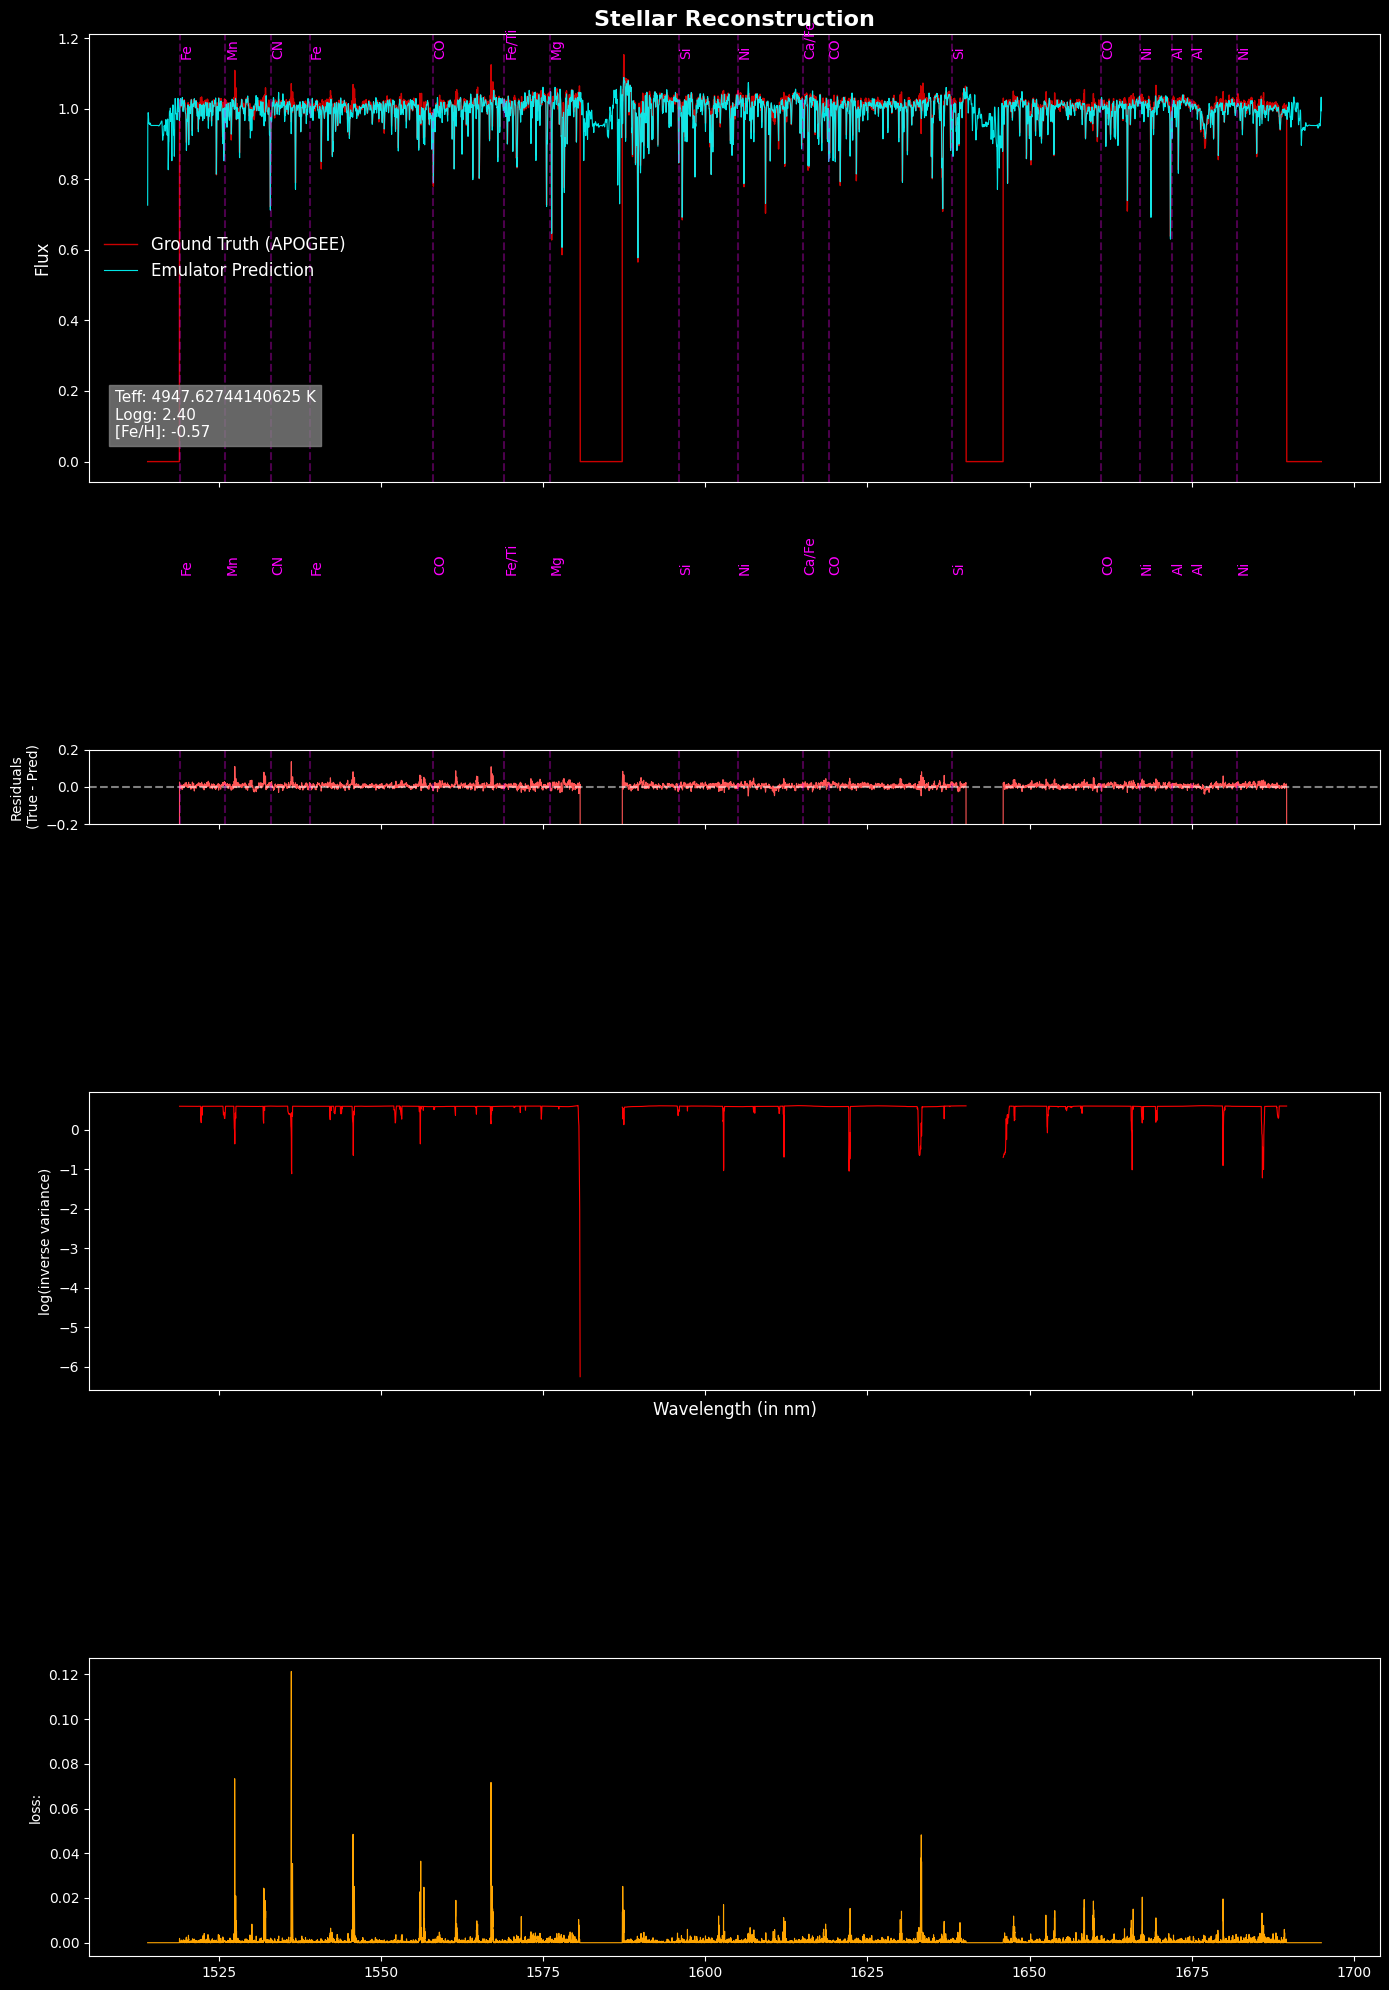

In [28]:

#----SAVE AND PREDICT-----

import matplotlib.pyplot as plt

model=tf.keras.models.load_model('/kaggle/working/final_model.keras')




def plot_spectrum_comparison(y_true, y_pred,ivar=None,loss=None, labels=None, title="Stellar Reconstruction"):
    plt.style.use('dark_background') #dark mode >>>>>> 
    wavelengths=np.logspace(np.log10(1514),np.log10(1695),config.OUTPUT_LENGTH)
    # APOGEE takes log wavelengths to space their pixels
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(
        4, 1, figsize=(14, 20), 
        gridspec_kw={'height_ratios': [3,0.5,2,2]}, 
        sharex=True
    )
    
    
    #TOP= SPECTROGRAMS   
    ax1.plot(wavelengths, y_true, color='red', alpha=0.8, linewidth=1, label='Ground Truth (APOGEE)')
    ax1.plot(wavelengths, y_pred, color='cyan', alpha=0.9, linewidth=0.8, label='Emulator Prediction')
    ax1.set_ylabel("Flux", fontsize=12, color='white')
    ax1.set_title(title, fontsize=16, fontweight='bold', color='white')
    ax1.legend(frameon=False, fontsize=12)

    
    #Strong spectral lines that can be seen in stars collected from APOGEE
    # AI generated, couldn't bother looking it up myself (I'll do it later)
    lines = [
        # --- Iron Peak & Core Elements ---
        (1519, "Fe"),     # Strong Iron anchor
        (1526, "Mn"),     # Manganese (Deep Line Driver)
        (1539, "Fe"),     # Strong Iron
        (1569, "Fe/Ti"),  # Strong blend
        (1576, "Mg"),     # Magnesium Triplet Center (The "Big One")
        (1605, "Ni"),     # Nickel (Deep Line Driver)
        (1615, "Ca/Fe"),  # Calcium & Iron
        (1667, "Ni"),     # Nickel
        (1682, "Ni"),     # Nickel

        # --- Alpha Elements ---
        (1596, "Si"),     # Silicon (Very distinctive dip)
        (1638, "Si"),     # Silicon
        (1672, "Al"),     # Aluminum (The "Deepest" single line usually)

        # --- Molecular Bandheads (The "Continuum Shapers") ---
        (1533, "CN"),     # Cyanogen band
        (1558, "CO"),     # Carbon Monoxide Bandhead (Start of 'sawtooth')
        (1619, "CO"),     # CO Bandhead
        (1661, "CO"),     # CO Bandhead (Very strong in cool stars)
        (1675, "Al"),
    ]
    
    for wl, name in lines:
        ax1.axvline(x=wl, color='magenta', alpha=0.3, linestyle='--')
        ax1.text(wl, 1.15, name, color='magenta', rotation=90, fontsize=10)
        
    #BOTTOM=RESIDUALS
    #compare how well the model fits the data
    residuals = y_true - y_pred
    ax2.set_ylim(-0.2,0.2)
    ax2.plot(wavelengths, residuals, color='#FF5555', linewidth=0.8)
    ax2.axhline(0, color='white', linestyle='--', alpha=0.5)
    ax2.set_ylabel("Residuals\n(True - Pred)", fontsize=10)
    
    
    for wl, name in lines:
        ax2.axvline(x=wl, color='magenta', alpha=0.3, linestyle='--')
        ax2.text(wl, 1.15, name, color='magenta', rotation=90, fontsize=10)
   # ax2.set_ylim(-0.2, 0.2)# => hopefully my model fits good enough for me to do this (it didn't ;-;)
    
    # show imp labels
    if labels is not None:
        info_str = f"Teff: {labels[0]} K\nLogg: {labels[1]:.2f}\n[Fe/H]: {labels[2]:.2f}"
        ax1.text(0.02, 0.1, info_str, transform=ax1.transAxes, 
                 bbox=dict(facecolor='grey', alpha=0.8, edgecolor='gray'),
                 fontsize=11, color='white')
    ax3.plot(wavelengths,np.log(ivar)-10,color='red',linewidth=0.8)
    ax3.set_ylabel("log(inverse variance)",fontsize=10)
    ax3.set_xlabel("Wavelength (in nm)", fontsize=12)
    if(loss!=None):
        ax4.plot(wavelengths,loss,color='orange',linewidth=0.8)
        ax4.set_ylabel("loss:",fontsize=10)
    fig.tight_layout() 
    fig.savefig("/kaggle/working/spectrogram_1.jpg")
    fig.show()

#generate sample spectrograms
for batch_labels, batch_spectra in val_ds.take(1):
   
    preds = model.predict(batch_labels)
    
    idx = 3
    true_spec = batch_spectra[idx, :, 0] 
    ivar=batch_spectra[idx,:,1]
    pred_spec = preds[idx, :, 0]
    star_labels = batch_labels[idx]
    star_labels=star_labels*STD_TENSOR+MEAN_TENSOR
    loss=sobolev_loss_arr(batch_spectra[idx:(idx+1),:,:], preds[idx:(idx+1),:,:])
    loss=loss[0,:,0]
    plot_spectrum_comparison(true_spec, pred_spec,ivar,loss, labels=star_labels)
    print(loss.shape)
    break